In [ ]:
 У нас имеется база данных в кикхаусе, куда ежедневно записываются данные по пользователям ленты новостей.
Лента новостей представляет из себя посты с возможностью их просматривать, лайкать, и также отправлять сообщения
друг другу. Действия по ленте новостей это like и view, действия по месссенджеру заполняются отдельной схемой в БД
и включают просто сообщения, кому и когда. В целом, лента и мессенджер составляют некое приложение, которое мы 
хотим развивать, наполняя новыми пользователями и поддерживая их активность.

In [ ]:
''' Задача
Автоматическая отправка аналитической сводки в телеграм каждое утро:
1. Текст с информацией о значениях ключевых метрик за предыдущий день
2. График с значениями метрик за предыдущие 7 дней
Метрики: DAU, Просмотры, Лайки, CTR '''

In [1]:
import pandahouse as ph
# Строка подключения к кликхаус
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Запрос исходной таблицы ленты новостей из БД для понимания структуры таблицы
feed = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""

In [2]:
# Наша исходная таблица ленты новостей
df_table_feed = ph.read_clickhouse(feed, connection=connection)
df_table_feed.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,12827,2004,like,2025-01-03 00:00:00,1,43,Turkey,İzmir,Android,ads,2
1,20565,1942,like,2025-01-03 00:00:00,0,23,Russia,Moscow,iOS,ads,4
2,114053,1915,view,2025-01-03 00:00:00,1,56,Russia,Kirov,Android,organic,3
3,115273,1984,view,2025-01-03 00:00:00,1,21,Russia,Moscow,iOS,organic,3
4,122707,1850,view,2025-01-03 00:00:01,1,25,Russia,Mirnyy,iOS,organic,1


In [ ]:
'''Ниже ячейка с кодом для DAG, а далее ячейки с отдельными функциями из DAG'''

In [ ]:
from airflow.decorators import dag, task # Для обьявления @dag, @task
from datetime import date, timedelta # Для работы с временем
from telegram import Bot, Update # Для работы с ботом
# Общие штуки для данных и рисования
import matplotlib.pyplot as plt
import seaborn as sns
import io # для перевода графиков и сообщений в бинарные данные и передача в телеграмм
import pandas as pd
import pandahouse as ph
from matplotlib.dates import DateFormatter, DayLocator # Изменять масштаб и частоту меток на осях графиков
# Токен бота телеграмм
my_token = 'my_token'
# Данные из кликхауса за последние 7 дней
q = '''SELECT toDate(time) date_t, count(user_id) as DAU,
           countIf(action, action = 'view') as views,
           countIf(action, action = 'like') as likes,
           likes/views as CTR
        FROM simulator_20250120.feed_actions
        WHERE date_t >= today() - 7 and date_t < today()
        GROUP BY  date_t
        '''
# Соединение с кликхаусом
connection = {'host': 'https://clickhouse.lab.karpov.courses', 
             'database':'simulator_20250120', 'user':'student',
             'password':'dpo_python_2020'}
# Запись данных из кликхауса в датафрейм
df = ph.read_clickhouse(q, connection=connection)

# Создаем объект бота
bot = Bot(token=my_token) 
# Получаем последние обновления
updates = bot.get_updates()
# chat_id это куда бот будет отправлять сообщения - сначало нужно дабавить бот в чат
chat_id = updates[-1].message.chat_id 

# Функция формирующая строку отчета с оперативными цифрами по метрикам 
def string_info():
    yesterday = pd.Timestamp.now().normalize() - pd.Timedelta(days=1)# Дата - вчера, без времени
    past_day = df[df['date_t'] == yesterday]
    metrics = (
        f"Метрики за вчера:\n"
        f"DAU - {past_day.DAU.values[0]}, "
        f"Views - {past_day.views.values[0]}, "
        f"Likes - {past_day.likes.values[0]}, "
        f"CTR - {past_day.CTR.values[0]:.2%}")
    return bot.send_message(chat_id=chat_id, text=metrics) 
# Функция строит графики метрик и отправляет их от имени бота
def send_plt():
    # Создаем фигуру и 3 вертикальных субплoта
    fig, axes = plt.subplots(3, 1, figsize=(6, 8))

    # Общие настройки для всех графиков
    plt.style.use('seaborn')  # Улучшенный стиль графиков
    fig.suptitle('Metrics Last 7 Day', fontsize=8, y=1.02)
    date_format = DateFormatter("%d-%m") # Меняем формат на оси ОХ
    #  График DAU
    axes[0].plot(df['date_t'], df['DAU'], color='tab:blue', marker='o', linestyle='-',
                linewidth=2, markersize=5)
    axes[0].set_title('Daily Active Users')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Users')
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_formatter(date_format)

    #  График CTR
    axes[1].plot(df['date_t'], df['CTR'], color='tab:green', 
        marker='s', linestyle='--', linewidth=2, markersize=5)
    axes[1].set_title('CTR')
    axes[1].set_xlabel('Date')
    axes[1].xaxis.set_major_formatter(date_format)
    axes[1].set_ylabel('CTR')
    axes[1].grid(True, alpha=0.3)

    #  График Likes и Views
    axes[2].plot(df['date_t'], df['likes'], color='tab:red', 
        marker='^', linestyle='-', linewidth=2, label='Likes', markersize=5)

    axes[2].plot(df['date_t'], df['views'], color='tab:orange', 
        marker='v', linestyle='--', linewidth=2, label='Views', markersize=5)

    axes[2].set_title('Likes & Views')
    axes[2].set_xlabel('Date')
    axes[2].xaxis.set_major_formatter(date_format)
    axes[2].set_ylabel('Count')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()

    plot_object = io.BytesIO() # Создаем бинарный объект
    plt.savefig(plot_object) # Сохраняем графики в него
    plot_object.seek(0)     # Возвращаем курсор в начало объекта чтоб API телеграма читало с начала
    plot_object.name = 'metrics.png' # Присваиваем имя
    plt.close() # Закрываем объект 
    return bot.send_photo(chat_id=chat_id, photo=plot_object)

# Аргументы DAG
default_args = {
    'owner': 'A.Dotsenko',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=4),
    'start_date': datetime(2025, 2, 24)}
schedule_interval = '0 8 * * *' # Время (час) запуска
# Определяем сам DAG
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def add_plt_telegram_dotsenko():
    
    @task() # Отправка сообщения
    def send_mess():
        string_info()
    send_mess()    
        
    @task() # Отправка графиков
    def send_plt_table():
        send_plt()
    send_plt_table()
# Вызываем сам   DAG  
add_plt_telegram_dotsenko = add_plt_telegram_dotsenko()   

In [ ]:
'''
Посмотрим как работают функции из кода отдельно и посмотрим на их выходные данные'''

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import io # для перевода графиков и сообщений в бинарные данные и передача в телеграмм
import pandas as pd
import pandahouse as ph
from matplotlib.dates import DateFormatter, DayLocator

In [4]:
# Запрос данных DAU, views, likes, CTR
q = '''SELECT toDate(time) date_t, count(user_id) as DAU,
           countIf(action, action = 'view') as views,
           countIf(action, action = 'like') as likes,
           likes/views as CTR
        FROM simulator_20250120.feed_actions
        WHERE date_t >= today() - 7 and date_t < today()
        GROUP BY  date_t
        '''
# Соединение с кликхаусом
connection = {'host': 'https://clickhouse.lab.karpov.courses', 
             'database':'simulator_20250120', 'user':'student',
             'password':'dpo_python_2020'}
# Запись данных из кликхауса в датафрейм
df = ph.read_clickhouse(q, connection=connection)

In [2]:
# Функция которая печатает значение ключевых метрик за вчера
def string_info():
    yesterday = pd.Timestamp.now().normalize() - pd.Timedelta(days=1)
    past_day = df[df['date_t'] == yesterday]
    metrics = (
        f"Метрики за вчера:\n"
        f"DAU - {past_day.DAU.values[0]}, "
        f"Views - {past_day.views.values[0]}, "
        f"Likes - {past_day.likes.values[0]}, "
        f"CTR - {past_day.CTR.values[0]:.2%}")
    
    return metrics

In [6]:
print(string_info())

Метрики за вчера:
DAU - 1015944, Views - 833754, Likes - 182190, CTR - 21.85%


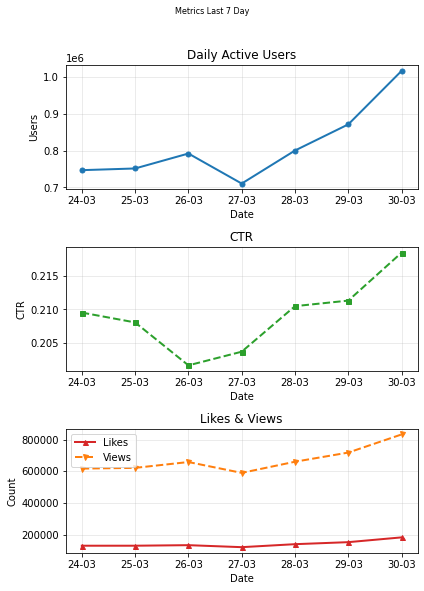

In [7]:
# Создаем фигуру и 3 вертикальных субплoта
fig, axes = plt.subplots(3, 1, figsize=(6, 8))

# Общие настройки для всех графиков
plt.style.use('default')  # Улучшенный стиль графиков
fig.suptitle('Metrics Last 7 Day', fontsize=8, y=1.02)
date_format = DateFormatter("%d-%m")
#  График DAU
axes[0].plot(df['date_t'], df['DAU'], color='tab:blue', marker='o', linestyle='-',
            linewidth=2, markersize=5)
axes[0].set_title('Daily Active Users')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Users')
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(date_format)


#  График CTR
axes[1].plot(df['date_t'], df['CTR'], color='tab:green', 
    marker='s', linestyle='--', linewidth=2, markersize=5)
axes[1].set_title('CTR')
axes[1].set_xlabel('Date')
axes[1].xaxis.set_major_formatter(date_format)
axes[1].set_ylabel('CTR')
axes[1].grid(True, alpha=0.3)


#  График Likes и Views
axes[2].plot(df['date_t'], df['likes'], color='tab:red', 
    marker='^', linestyle='-', linewidth=2, label='Likes', markersize=5)

axes[2].plot(df['date_t'], df['views'], color='tab:orange', 
    marker='v', linestyle='--', linewidth=2, label='Views', markersize=5)

axes[2].set_title('Likes & Views')
axes[2].set_xlabel('Date')
axes[2].xaxis.set_major_formatter(date_format)
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
plt.tight_layout()